<a href="https://colab.research.google.com/github/Suvish13/Fuzzy-C-Means-Clustering_for-Groundwaterpotentialzone-mapping/blob/main/GWPZ_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
!pip install rasterio scikit-fuzzy matplotlib tqdm
!apt-get install -y gdal-bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 62.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.

In [16]:
import os
import glob
from tqdm import tqdm
import subprocess

input_dir = "/content/data"
resize_dir = "/content/Resaize"
os.makedirs(fixed_dir, exist_ok=True)

print("resize rasters")

for raster_path in tqdm(glob.glob(f"{input_dir}/*.tif")):
    file_name = os.path.basename(raster_path)
    fixed_path = os.path.join(resize_dir, file_name)

    cmd = f"gdal_translate -of GTiff -co COMPRESS=LZW \"{raster_path}\" \"{fixed_path}\""
    subprocess.run(cmd, shell=True)

print(f"Fixed rasters saved to {resize_dir}")


resize rasters


100%|██████████| 6/6 [00:00<00:00, 10.04it/s]

Fixed rasters saved to /content/Resaize


6 rasters aligned
Running Fuzzy C-Means clustering
Clustering done - FPC = 0.526

 Mean normalized factor values per cluster:
Cluster 0: {'Rainfall.tif': np.float32(0.866), 'DD.tif': np.float32(0.77), 'Soil.tif': np.float32(0.151), 'LULC.tif': np.float32(0.593), 'Geology.tif': np.float32(0.246), 'LD.tif': np.float32(0.576)}
Cluster 1: {'Rainfall.tif': np.float32(0.746), 'DD.tif': np.float32(0.694), 'Soil.tif': np.float32(0.72), 'LULC.tif': np.float32(0.577), 'Geology.tif': np.float32(0.311), 'LD.tif': np.float32(0.391)}
Cluster 2: {'Rainfall.tif': np.float32(0.566), 'DD.tif': np.float32(0.567), 'Soil.tif': np.float32(0.641), 'LULC.tif': np.float32(0.524), 'Geology.tif': np.float32(0.984), 'LD.tif': np.float32(0.357)}
Cluster 3: {'Rainfall.tif': np.float32(0.023), 'DD.tif': np.float32(0.024), 'Soil.tif': np.float32(0.012), 'LULC.tif': np.float32(0.03), 'Geology.tif': np.float32(0.399), 'LD.tif': np.float32(0.022)}
Cluster 4: {'Rainfall.tif': np.float32(0.338), 'DD.tif': np.float32(0.489

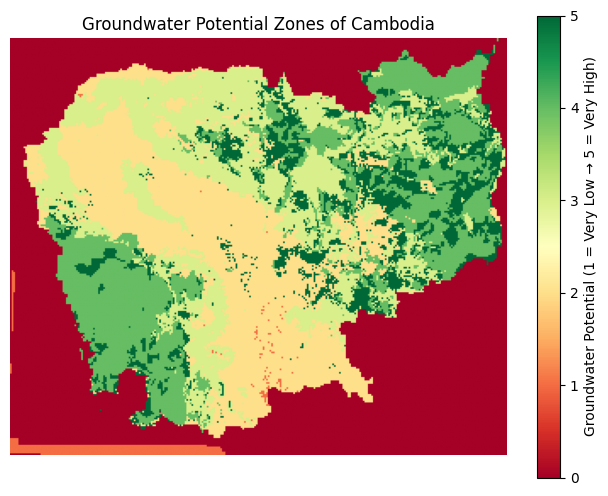

In [17]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import skfuzzy as fuzz
import glob
import matplotlib.pyplot as plt
import csv

input_dir = resize_dir
output_dir = "Output"
os.makedirs(output_dir, exist_ok=True)

reference_raster = os.path.join(input_dir, "/content/Resaize/Geology.tif")
n_clusters = 5

weights = {
    "rainfall": 0.30,
    "drainage": 0.20,
    "lineament": 0.10,
    "lulc": 0.20,
    "soil": 0.20
}

influence = {
    "rainfall": "positive",
    "drainage": "negative",
    "lineament": "positive",
    "lulc": "positive",
    "soil": "positive"
}

ref = rasterio.open(reference_raster)
ref_profile = ref.profile
ref_transform, ref_crs = ref.transform, ref.crs
ref_width, ref_height = ref.width, ref.height

aligned_rasters, band_names = [], []

for raster in glob.glob(f"{input_dir}/*.tif"):
    name = os.path.basename(raster)
    band_names.append(name)
    with rasterio.open(raster) as src:
        data = src.read(1).astype(float)
        data[data == src.nodata] = np.nan
        dst_data = np.empty((ref_height, ref_width), dtype=np.float32)

        if any(x in name.lower() for x in ["lulc", "soil", "geology"]):
            resample_method = Resampling.nearest
        else:
            resample_method = Resampling.bilinear

        reproject(
            source=data,
            destination=dst_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=resample_method
        )
        aligned_rasters.append(dst_data)

print(f"{len(aligned_rasters)} rasters aligned")

def normalize(arr):
    a_min, a_max = np.nanmin(arr), np.nanmax(arr)
    return (arr - a_min) / (a_max - a_min + 1e-9)

stack = np.stack(aligned_rasters, axis=0)
mask = np.any(np.isnan(stack), axis=0)
norm_stack = np.array([normalize(band) for band in stack])
n_bands, rows, cols = norm_stack.shape

data = norm_stack.reshape(n_bands, -1)
data = np.where(np.isnan(data), 0, data)

print("Running Fuzzy C-Means clustering")
cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2.0, error=0.005, maxiter=1000
)
print(f"Clustering done - FPC = {fpc:.3f}")

cluster_map = np.argmax(u, axis=0).reshape(rows, cols)
cluster_map = np.where(mask, np.nan, cluster_map)

means = []
for k in range(n_clusters):
    mask_k = cluster_map == k
    band_means = [np.nanmean(norm_stack[i][mask_k]) for i in range(n_bands)]
    means.append(band_means)
means = np.array(means)

print("\n Mean normalized factor values per cluster:")
for i, vals in enumerate(means):
    print(f"Cluster {i}: {dict(zip(band_names, np.round(vals,3)))}")

cluster_scores = np.zeros(n_clusters)
for i, name in enumerate(band_names):
    key = next((k for k in weights.keys() if k in name.lower()), None)
    if key:
        w = weights[key]
        if influence[key] == "positive":
            cluster_scores += means[:, i] * w
        else:
            cluster_scores += (1 - means[:, i]) * w
    else:
        print(f" No weight defined for {name}, skipping.")

ranking = np.argsort(cluster_scores)
labels = ["Very Low", "Low", "Moderate", "High", "Very High"]

print("\n Weighted cluster scores:", np.round(cluster_scores,3))

label_map = np.zeros_like(cluster_map, dtype=np.float32)
for i, rank in enumerate(ranking):
    label_map[cluster_map == rank] = i + 1

out_path = os.path.join(output_dir, "GWPZ_Map.tif")
ref_profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)
with rasterio.open(out_path, "w", **ref_profile) as dst:
    dst.write(label_map, 1)

print(f"\n Weighted & labeled GWPZ raster saved → {out_path}")
print("Labels (1–5):", labels)

csv_path = os.path.join(output_dir, "cluster_summary.csv")
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Cluster", "Weighted Score", "Label"] + band_names)
    for i in range(n_clusters):
        writer.writerow([i, np.round(cluster_scores[i],3), labels[np.where(ranking == i)[0][0]]] + list(np.round(means[i],3)))
print(f" Cluster summary CSV saved → {csv_path}")

plt.figure(figsize=(8,6))
plt.imshow(label_map, cmap="RdYlGn")
cbar = plt.colorbar()
cbar.set_label("Groundwater Potential (1 = Very Low → 5 = Very High)")
plt.title("Groundwater Potential Zones of Cambodia")
plt.axis("off")
plt.show()
